In [1]:
%matplotlib inline
import pandas as pd

# Obtaining data from SatNOGS
- Need to create an account in [db.satnogs.org](http://db.satnogs.org) to download telemetry
  - Accounts on [network-dev.satnogs.org](http://network-dev.satnogs.org) are separate

- Choice of frames to download: everything/last week/last month
  - Clicking download from the dropdown, or visiting the links below, means you wait for an email with a link
      - https://db.satnogs.org/frames/[norad_id]/
      - https://db.satnogs.org/frames/[norad_id]/1
      - https://db.satnogs.org/frames/[norad_id]/2
  - The link was to a CSV file; only 1.7 MB, so it has been temporarily included here

In [2]:
!head data/43617-482-20181022T023205Z-month.csv --lines 3

2018-10-22 01:59:41|AE6CB2A4827260AE9464B09CB0E103F0930E07700018102201575200320035001B000202B20305013800F301050000000CFF7F12806620FB79193DF95112406340F9A81BAC000806600950094008B014146464181022015755002E0034001B000102AC02FF013500EF00FF00000013FFC012406680FD690F06FC2727128064A0F9F007D1000809700BA00ED000000C0C0606181022015258007B002CFF4A005700A8FFFD0300080016800C8018102201533400A5002DFF5A0082002793FFFE0380088013000A001900B603B60070275ECEB000005B9CFB0100090F1117006A198D0000281901910000000007000000000200000000070000000002000000000700000000020000000007656C6661565E
2018-10-22 00:26:07|AE6CB2A4827260AE9464B09CB0E103F0930E07F000181022002545003000320016000202A702FF013300F0010400050013FCCF12C06560FCBF17F0F6A812606260F6FC1ACD00080DD00AF00AF00A1012126060181022002547001F002F0015000102A202FF013F00ED00FE0000000EFFBB1240668000160F01F77212806360F76606E4000809900AD00C2000000C0C0505181022002522FFFEFF66FFEDFFC80016FF370480FF00FF00FB0018102200163300590090FF5900310096006105000A801F80FB801900B503EA00461ACCAF0

In [3]:
df_data = pd.read_csv("data/43617-482-20181022T023205Z-month.csv", names=['Date', 'Binary'], sep='|')
df_data.head()

,Date,Binary
0,2018-10-22 01:59:41,AE6CB2A4827260AE9464B09CB0E103F0930E0770001810...
1,2018-10-22 00:26:07,AE6CB2A4827260AE9464B09CB0E103F0930E07F0001810...
2,2018-10-22 00:25:01,AE6CB2A4827260AE9464B09CB0E103F0930E07F0001810...
3,2018-10-22 00:25:00,AE6CB2A4827260AE9464B09CB0E103F0930E07F0001810...
4,2018-10-22 00:24:28,AE6CB2A4827260AE9464B09CB0E103F0930E07F0001810...


# Parsing data
To get started we have included the kaitai parsers in the repo ([check `kaitai_parsers` folder](kaitai_parsers)). We've generated them using [DL4DP's struct](https://github.com/DL4PD/satnogs-kaitai-structs). The command to generate them is:

`kaitai-struct-compiler satnogs-kaitai-structs/ax25-elfin-tlm-parser.ksy --target python`

In [4]:
from kaitai_parsers.ax25frames import Ax25frames
import binascii

In [5]:
raw = binascii.unhexlify(df_data['Binary'][0])
pkt = Ax25frames.from_bytes(raw)

In [6]:
dir(pkt)

['DestAddress',
 'Hdr',
 'IFrame',
 'SrcAddress',
 'UiFrame',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_io',
 '_parent',
 '_raw_ax25_header',
 '_read',
 '_root',
 'ax25_header',
 'close',
 'frametype',
 'from_bytes',
 'from_file',
 'from_io']

In [7]:
from kaitai_parsers.elfin import Elfin
pkt2 = Elfin.from_bytes(raw)
type(pkt2.ax25_info) is Elfin.ElfinTlmData

False

In [8]:
dir(pkt2)

['Ax25Hdr',
 'DestCallsign',
 'ElfinCmdResponse',
 'ElfinHskpPacket',
 'ElfinTlmData',
 'SrcCallsign',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_io',
 '_parent',
 '_raw__raw_ax25_info',
 '_raw_ax25_header',
 '_raw_ax25_info',
 '_read',
 '_root',
 'ax25_header',
 'ax25_info',
 'close',
 'from_bytes',
 'from_file',
 'from_io']

# Decoding telemetry

In [9]:
df_data['pkt_type'] = None
df_data['pkt'] = None

for index, beacon in df_data.iterrows():
    raw = binascii.unhexlify(beacon['Binary'])
    pkt = Elfin.from_bytes(raw)
    df_data.loc[index, 'pkt'] = pkt.ax25_info
    df_data.loc[index, 'pkt_type'] = type(pkt.ax25_info)

In [10]:
# Filter telemetry packets
df_data = df_data[df_data.pkt_type == Elfin.ElfinTlmData]

In [11]:
from datetime import datetime
df_data['Time'] = 0

def decode_date(date):
    date_str = str(hex(date))
    return int(date_str[2:])

for index, beacon in df_data[:-1].iterrows():
    year = decode_date(beacon.pkt.elfin_hskp_pwr1_rtcc_year) + 2000
    month = decode_date(beacon.pkt.elfin_hskp_pwr1_rtcc_month)
    day = decode_date(beacon.pkt.elfin_hskp_pwr1_rtcc_day)
    hour = decode_date(beacon.pkt.elfin_hskp_pwr1_rtcc_hour)
    minute = decode_date(beacon.pkt.elfin_hskp_pwr1_rtcc_minute)
    second = decode_date(beacon.pkt.elfin_hskp_pwr1_rtcc_second)
    df_data.loc[index, "Time"] = datetime(year, month, day, hour, minute, second)

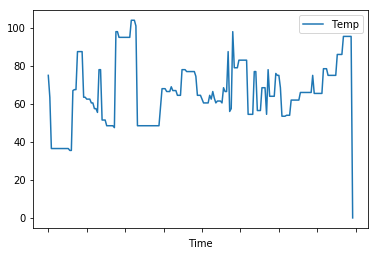

In [12]:
df_data['Temp'] = 0

for index, beacon in df_data[:-1].iterrows():
    temp = beacon.pkt.elfin_hskp_pwr1_bat_mon_1_temperature_register
    temp = (temp * 32.0) * 0.125
    temp = temp * 0.00390625
    df_data.loc[index, "Temp"] = temp

df_data.plot(x='Time', y='Temp')

# Next steps
  - Assemble telemetry data from packets using Elfin kaitai struct
  - Automate data download from SatNOGS Network
    - Settings page for db account has API key: https://db.satnogs.org/users/edit/
    - API doc for db: https://db.satnogs.org/api/
    - There's a CLI for downloading SatNOGS data, but I'm unsure if this will grab telemetry: https://github.com/deckbsd/glouton-satnogs-data-downloader